# iSNVs in SCAN samples

In this analysis, we look at iSNVs in SCAN SARS-CoV-2 samples with a Ct < 22.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
def load_df(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        df = pd.read_csv(tfile, sep = '\t')
        if 'nwgc_id' in df.columns:
            df['nwgc_id'] = df.nwgc_id.astype('str')
        if 'position' and 'variant' in df.columns:
            df['snv'] = df['position'].astype('str').str.cat(df['variant'],sep="")
    return df

scan_snvs = load_df('../results/snvs_scan_all.tsv')
scan_snvs = scan_snvs[scan_snvs.avg_ct < 22]

## Labelling variants in >1 sample

In [3]:
def find_shared_snvs(df):
    shared_snvs = df.groupby('snv').filter(lambda x: len(x) > 1)
    snvs = shared_snvs['snv'].unique()
    status = []
    for i in df.index:
        if df.loc[i, 'snv'] in snvs:
            status.append('shared')
        else:
            status.append('not_shared')
    df['is_shared'] = status
    return df

scan_snvs = find_shared_snvs(scan_snvs)

## How many SNVs per sample?

(0.0, 25.0)

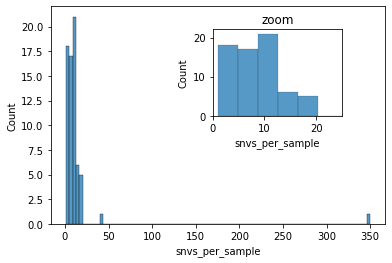

In [4]:
df_sample = pd.value_counts(scan_snvs.nwgc_id).to_frame(name='snvs_per_sample').rename_axis('nwgc_id').reset_index()


fig, ax = plt.subplots()

sns.histplot(df_sample, x='snvs_per_sample', ax=ax)

ax2 = plt.axes([0.5, 0.5, .3, .3])
sns.histplot(df_sample, x='snvs_per_sample', ax=ax2)
ax2.set_title('zoom')
ax2.set_xlim([0,25])


In [27]:
len(df_sample)

69

In [5]:
print(df_sample['snvs_per_sample'].median())

8.0


## What are the frequency of iSNVs?

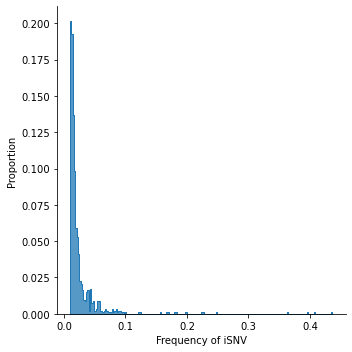

In [6]:
ax = sns.displot(scan_snvs, x='frequency', stat='probability', common_norm=False, element='step')
ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')



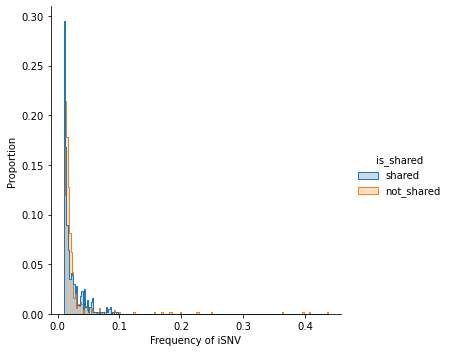

In [7]:
ax = sns.displot(scan_snvs, x='frequency', hue='is_shared', stat='probability', common_norm=False, element='step')
ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')

## What types of mutations are the variants?

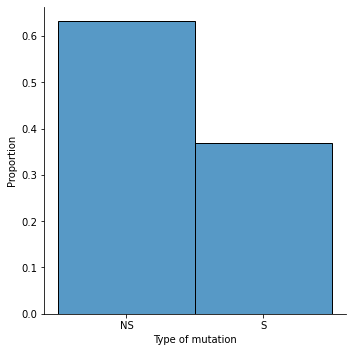

In [8]:
def plot_types(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')

    ax = sns.displot(df, x='mut_type', stat='probability')
    ax.set(ylabel='Proportion', xlabel='Type of mutation')
    return plt.show()

plot_types(scan_snvs)

<function matplotlib.pyplot.show(close=None, block=None)>

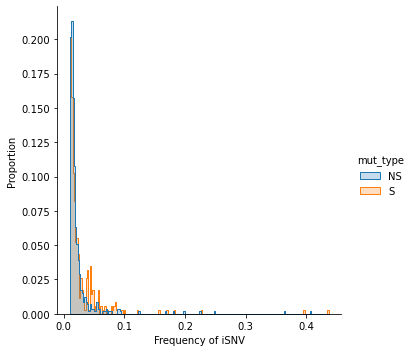

In [9]:
def plot_freq(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')

    ax = sns.displot(df, x='frequency', hue='mut_type', stat='probability', common_norm=False, element='step')
    ax.set(ylabel='Proportion', xlabel='Frequency of iSNV')
    return plt.show

plot_freq(scan_snvs)



<function matplotlib.pyplot.show(close=None, block=None)>

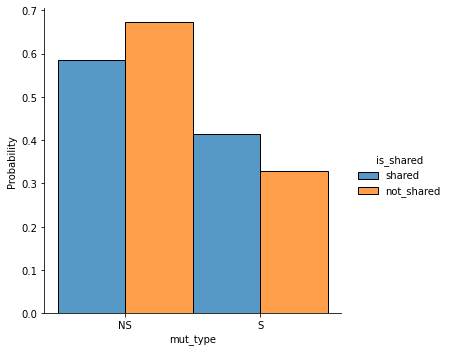

In [10]:
def plot_shared_snvs(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')

    ax = sns.displot(df, x = 'mut_type', hue = 'is_shared', multiple='dodge', stat='probability', common_norm=False)
    return plt.show

plot_shared_snvs(scan_snvs)

In [11]:
def chi2(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')
    cross_tab = pd.crosstab(df['is_shared'], df['mut_type'])
    chi2, p, dof, ex = stats.chi2_contingency(cross_tab, correction = False)
    return p

chi2(scan_snvs)

0.006233314757706038

<function matplotlib.pyplot.show(close=None, block=None)>

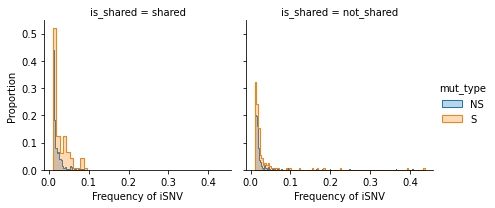

In [12]:
def plot_freq_shared(df):
    df['mut_type'] = df.mut_type.replace(to_replace='NC', value='S')
    g = sns.FacetGrid(df, col='is_shared', hue='mut_type', hue_order=['NS', 'S'])
    g.map(sns.histplot,'frequency', stat='probability', element='step', alpha=0.3, common_norm=False)
    g.set(ylabel='Proportion', xlabel='Frequency of iSNV')
    g.add_legend()
    return plt.show

plot_freq_shared(scan_snvs)

## Where in the genome are iSNVs located?

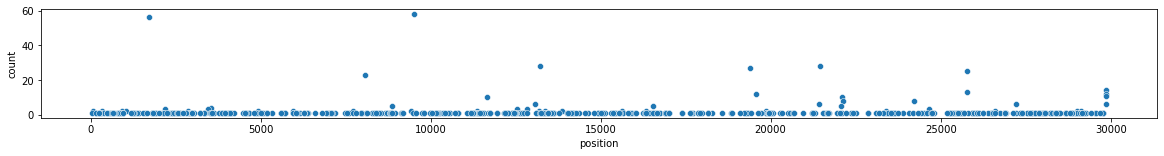

In [13]:
df_location = pd.value_counts(scan_snvs.position).to_frame(name='count').rename_axis('position').reset_index()
plt.figure(figsize=(20,2))
ax = sns.scatterplot(data=df_location, x='position', y='count')

## Are iSNVs share by transmission cluster?

In [14]:
clusters = load_df('../data/cluster_assignment.tsv')

In [15]:
scan_snvs = scan_snvs.merge(clusters, how='left', on='strain')


In [17]:
def compare_pairwise(df):
    df = df[~df.cluster.isna()]
    df = df.sort_values(by=['cluster', 'avg_ct']).reset_index()
    samples = df['nwgc_id'].unique()
    length = len(samples)
    adj_matrix = np.zeros((length, length, 4))
    for indexA, sampleA in enumerate(samples):
        for indexB, sampleB in enumerate(samples):
            if indexA != indexB:
                dfA = df[df.nwgc_id==sampleA]
                dfB = df[df.nwgc_id==sampleB]
                comparison = 0
                if dfA.cluster.values[0] == dfB.cluster.values[0]:
                    comparison = 1
                df_merged = dfA.merge(dfB, how = 'inner', on ='snv')
                n_shared = len(df_merged.index)
                adj_matrix[indexA, indexB, 0] = n_shared
                adj_matrix[indexB, indexA, 0] = n_shared
                adj_matrix[indexA, indexB, 1] = comparison
                adj_matrix[indexB, indexA, 1] = comparison
    return adj_matrix

matrix = compare_pairwise(scan_snvs)

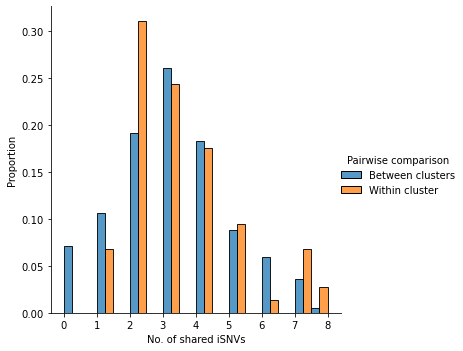

In [18]:
def shared_df(matrix):
    shared_m = matrix[:, :, 0]
    cluster_m = matrix[:, :, 1]
    length = len(shared_m)
    shared = shared_m[np.tril_indices(n=length, k=-1)]
    cluster = cluster_m[np.tril_indices(n=length, k=-1)]
    shared_df = pd.DataFrame({'n_shared':shared, 'cluster_comparison':cluster})
    return shared_df

shared_df = shared_df(matrix)

def plot_shared(df):
    ax = sns.displot(df, x='n_shared', hue = 'cluster_comparison', stat='probability', common_norm=False, multiple='dodge')
    ax.set(ylabel='Proportion', xlabel='No. of shared iSNVs')
    ax._legend.set_title('Pairwise comparison')
    new_labels = ['Between clusters', 'Within cluster']
    for t, l in zip(ax._legend.texts, new_labels): 
        t.set_text(l)
    return plt.show()

plot_shared(shared_df)

## Are iSNVs found in other datasets?

In [22]:
df_snv = pd.value_counts(scan_snvs.snv).to_frame(name='count').rename_axis('snv').reset_index()

muts = scan_snvs[['snv', 'mut_type', 'protein', 'position', 'aa_position']].drop_duplicates()

df_snv = df_snv.merge(muts, how='left')

In [24]:
def load_csv(file):
    '''
    Loads CSV as pandas df
    '''
    with open(file) as cfile:
        df = pd.read_csv(cfile, sep = ',', dtype = {'reference.position': 'Int64'})
        renamed = df.rename(columns={'reference.position': 'position', 'n.individuals': 'n_individuals'})
        renamed['position'] = renamed.position.astype('Int64')
        renamed['n_individuals'] = renamed.n_individuals.astype('Int64')
    return renamed

wi = load_df('../data/WI_iSNVs.tsv')
lythgoe = load_csv('../data/Lythgoe_iSNVs.csv')

In [25]:
def compare_lythgoe(df, lt):
    count = []
    lythgoe = []
    
    for i in df.index:
        pos = df.loc[i, 'position']
        if pos in list(lt.position):
            lythgoe.append('yes')
            lt_count = lt.loc[lt.position==pos, 'n_individuals'].values[0]
            count.append(int(lt_count))
        else:
            count.append(int(0))
            lythgoe.append('no')
    df['count_lythgoe'] = count
    df['in_lythgoe'] = lythgoe
    df.count_lythgoe = df.count_lythgoe.astype('Int64')
    return df

df_variant = compare_lythgoe(df_snv, lythgoe)

In [26]:
wi

,Unnamed: 0,SNV,counts
0,0,A15139C,66
1,0,T15167G,59
2,0,T15137G,40
3,0,T3037C,38
4,0,C15141A,37
...,...,...,...
371,0,A11451G,1
372,0,A11161G,1
373,0,A10930T,1
374,0,A10874G,1


In [29]:
def compare_wi(df, wi):
    wi['snv'] = wi['SNV'].str[1:]
    count = []
    wisconsin = []
    
    for i in df.index:
        snv = df.loc[i, 'snv']
        if snv in list(wi.snv):
            wisconsin.append('yes')
            wisconsin_count = wi.loc[wi.snv==snv, 'counts'].values[0]
            count.append(int(wisconsin_count))
        else:
            count.append(int(0))
            wisconsin.append('no')
    df['count_wisconsin'] = count
    df['in_wisconsin'] = wisconsin
    return df

df_variant = compare_wi(df_variant, wi)

In [32]:
def add_dataset(df):
    dataset = []
    for i in df.index:
        lythgoe = df.loc[i, 'in_lythgoe']
        wisconsin = df.loc[i, 'in_wisconsin']
        if lythgoe == 'yes' and wisconsin == 'yes':
            dataset.append('Wisconsin & Lythgoe')
        elif lythgoe == 'yes':
            dataset.append('Lythgoe')
        elif wisconsin == 'yes':
            dataset.append('Wisconsin')
        else:
            dataset.append('Only SCAN')
            
    df['dataset'] = dataset
    return df

df_variant = add_dataset(df_variant)
        

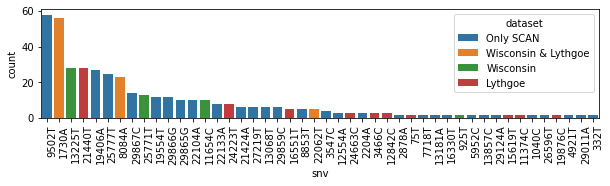

In [34]:
def plot_variants(df):
    pal = sns.color_palette("mako", as_cmap=True)
    sliced = df[df['count']> 1]
    plt.figure(figsize=(10,2))
    ax = sns.barplot(x='snv', y='count', hue='dataset', data=sliced, dodge=False)
    ax.set_xticklabels(labels = sliced['snv'], rotation=90, ha='left')
    return plt.show()

plot_variants(df_variant)